# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Lab 11 Interpreting Machine Learning Models 


**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai\
**Lab Team**: Marios Mattheakis, Hayden Joy, Chris Gumb, and Eleni Kaxiras<br/>
**Authors**: Kevin Rader, Pavlos Protopapas, Yongwhan Lim, and Chris Gumb
<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

# Table of Contents 
- Feature Importance 
- Permutation Importance
- ELI5
- Interpretation Through Predictions
- Surrogate Explainer Model
- LIME 
- SHAP
   

## Learning Goals

- Interpret the results of 'black box' machine learning models using several methods. 
- Explore the ELI5, LIME, and SHAP packages.


In [2]:
# required for SHAP and needs to be run before imports
!pip install numpy==1.20.0 numba==0.54.0

In [3]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import ensemble

# Here are the decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
import graphviz

np.random.seed(109)

ModuleNotFoundError: No module named 'graphviz'

In [4]:
# For the sake of time, we'll fit some models quickly and they won't converge
# We'll supress those pesky warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Model Interpretability 🔎

- As a data scientist, you need to know ins and outs of machine learning models.
- Often you need to provide a **trustworthy, transparent, and accountable explanation** to stakeholders beyond the final evaluation metrics (e.g., Accuracy, ROC-AUC score, etc.).
- To provide a good justification, we would do well to have an easily generalizable framework to explain a machine learning model.

But there are inherent trade-off between model interpretability and accuracy.\
And there are many ways to explain the machine learning models:
- Use only interpretable models
    - Linear regression, logistic regression, decision trees, etc.
    - But these are often times too simple and don't perform well!
- Use model specific interpretation methods
    - Lacks generalization because it is model dependent!
- Use **model-agnostic methods**

#### Data Wrangling

Today, we will be using the `Heart.csv` data set we've seen many times before.  We to predict `AHD` from the other features and then interpret the models predictions.\
For this reason it will be nice to have a description of all the features at hand.

The data includes:
- Age: displays the age of the individual.
- Sex: displays the sex of the individual using the following format :
    - 1 = male
    - 0 = female
- Chest-pain type: displays the type of chest-pain experienced by the individual using the following format :
    - typical angina
    - atypical angina
    - non—anginal pain
    - asymptotic
- Resting Blood Pressure: displays the resting blood pressure value of an individual in mmHg (unit)
- Serum Cholestrol: displays the serum cholesterol in mg/dl (unit)
- Fasting Blood Sugar: compares the fasting blood sugar value of an individual with 120mg/dl.
    - If fasting blood sugar > 120mg/dl then : 1 (true)
    - else : 0 (false)
- Resting ECG : displays resting electrocardiographic results
    - 0 = normal
    - 1 = having ST-T wave abnormality
    - 2 = left ventricular hyperthrophy
- Max heart rate achieved : displays the max heart rate achieved by an individual.
- Exercise induced angina :
    - 1 = yes
    - 0 = no
- ST depression induced by exercise relative to rest (`Oldspeak`)
- Peak exercise ST segment (`Slope`):
    - 1 = upsloping
    - 2 = flat
    - 3 = downsloping
- Number of major vessels (0–3) colored by flourosopy (`Ca`)
- Thal : displays the thalassemia :
    - normal
    - fixed defect
    - reversible defect
- Diagnosis of heart disease : Displays whether the individual is suffering from heart disease or not :
    - Yes
    - No

We'll read in the data and do a bit of preprocessing.

In [5]:
heart_df = pd.read_csv('data/Heart.csv', index_col=0)

In [6]:
print(heart_df.shape)
heart_df.head()

(303, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [7]:
heart_df.describe()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000
mean,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241
std,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


In [8]:
X = heart_df[['Age','Sex','ChestPain','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope','Ca','Thal']]
y = (heart_df['AHD']=='Yes').astype(int)

In [9]:
# These are our categorical columns
X = X.assign(ChestPain=X['ChestPain'].astype('category').cat.codes)
X = X.assign(Thal=X['Thal'].astype('category').cat.codes)

In [10]:
# The mode of Ca is 0
X['Ca']=X['Ca'].fillna(0)

In [11]:
# Here we're actually getting indices from the split call!
itrain, itest = train_test_split(range(X.shape[0]), train_size=0.80, stratify=heart_df.AHD)

X_train = X.iloc[itrain, :]
X_test = X.iloc[itest, :]
y_train = y.iloc[itrain]
y_test = y.iloc[itest]

In [12]:
# After preprocessing
X

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
1,63,1,3,145,233,1,2,150,0,2.3,3,0.0,0
2,67,1,0,160,286,0,2,108,1,1.5,2,3.0,1
3,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2
4,37,1,1,130,250,0,0,187,0,3.5,3,0.0,1
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,45,1,3,110,264,0,0,132,0,1.2,2,0.0,2
300,68,1,0,144,193,1,0,141,0,3.4,2,2.0,2
301,57,1,0,130,131,0,0,115,1,1.2,2,1.0,2
302,57,0,2,130,236,0,2,174,0,0.0,2,1.0,1


**Q:** 🤔 How were the categorical variables handled?  How were missing values treated?  Were these wise choices?

---

## Fitting Four Untuned ML Models

Start with 2 decision tree models and evaluate using AUC:

In [13]:
# fit a possibly underfit (depth = 3) decision tree classifier
dt3 = tree.DecisionTreeClassifier(max_depth = 3)
dt3.fit(X_train,y_train)

# fit an overfit (depth = 10) decision tree classifier
dt10 = tree.DecisionTreeClassifier(max_depth = 10)
dt10.fit(X_train,y_train);

In [14]:
# Evaluate using AUC
print("AUC on train for dt3:",sk.metrics.roc_auc_score(y_train,dt3.predict_proba(X_train)[:,1]))
print("AUC on test for dt3:",sk.metrics.roc_auc_score(y_test,dt3.predict_proba(X_test)[:,1]))

print("AUC on train for dt10:",sk.metrics.roc_auc_score(y_train,dt10.predict_proba(X_train)[:,1]))
print("AUC on test for dt10:",sk.metrics.roc_auc_score(y_test,dt10.predict_proba(X_test)[:,1]))

AUC on train for dt3: 0.894230107970566
AUC on test for dt3: 0.8398268398268398
AUC on train for dt10: 1.0
AUC on test for dt10: 0.6520562770562771


Now fit the two ensemble models: **Random Forest** and **AdaBoost**:

In [15]:
# fit random forest and adaboost models
randomforest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=10)
randomforest.fit(X_train,y_train);

adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=150,
    learning_rate=.05)
adaboost.fit(X_train,y_train);

In [16]:
# evaluating
print("AUC on train for randomforest:",sk.metrics.roc_auc_score(y_train,randomforest.predict_proba(X_train)[:,1]))
print("AUC on test for randomforest:",sk.metrics.roc_auc_score(y_test,randomforest.predict_proba(X_test)[:,1]))

print("AUC on train for adaboost:",sk.metrics.roc_auc_score(y_train,adaboost.predict_proba(X_train)[:,1]))
print("AUC on test for adaboost:",sk.metrics.roc_auc_score(y_test,adaboost.predict_proba(X_test)[:,1]))

AUC on train for randomforest: 0.9999999999999999
AUC on test for randomforest: 0.902056277056277
AUC on train for adaboost: 0.9955986520872018
AUC on test for adaboost: 0.8571428571428572


**Q**: 🤔 Which model performs best?  Which models are overfit?  How do you know?

## Variable Importance

Fill in the blanks below to calculate the variable importances from the 4 untuned models above.

In [17]:
X.columns[np.flip(np.argsort(dt3.feature_importances_))]

Index(['ChestPain', 'Oldpeak', 'Ca', 'MaxHR', 'Thal', 'Slope', 'ExAng',
       'RestECG', 'Fbs', 'Chol', 'RestBP', 'Sex', 'Age'],
      dtype='object')

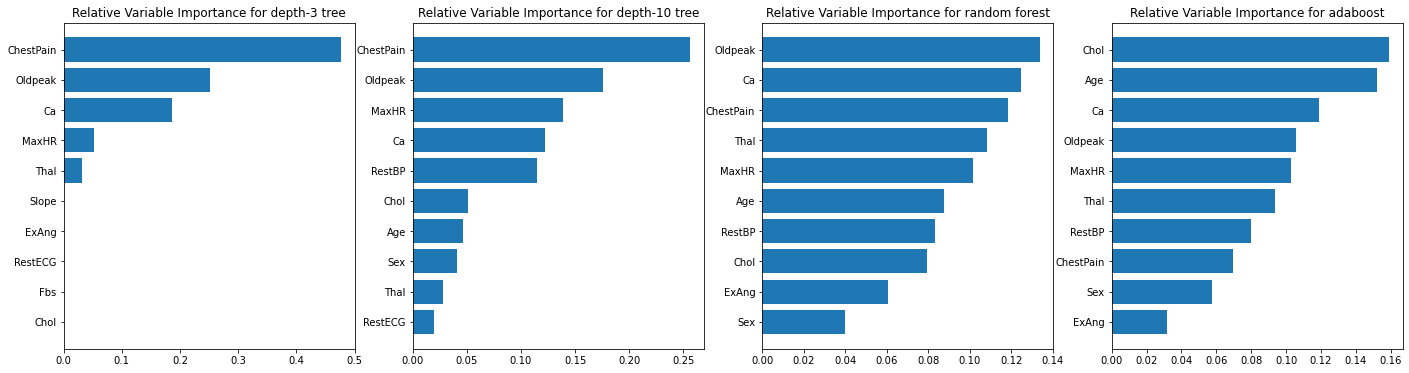

In [18]:
fig, axs = plt.subplots(1,4, figsize=(24,6))
models = {'depth-3 tree': dt3,
          'depth-10 tree': dt10,
          'random forest': randomforest,
          'adaboost': adaboost} 
num_features = 10 
for i, (name, model) in enumerate(models.items()):
    importances = model.feature_importances_
    order = np.argsort(importances)[-num_features:]
    axs[i].barh(range(num_features), importances[order], tick_label=X.columns[order]);
    axs[i].set_title(f"Relative Variable Importance for {name}")
                                  

**Q**: 🤔 How do these variable importance measures compare for these 4 models?  Which predictor is most important in general?  How is it related to `AHD`? 

**What other approaches can be taken to measure variable importance?**

One alternative for random forest:
- Record the prediction accuracy on the *oob* samples for each tree.
- Randomly permute the data for column $j$ in the *oob* samples, then record the accuracy again.
- The decrease in accuracy as a result of this permuting is averaged over all trees, and is used as a measure of the importance of variable $j$ in the random forest. 

This idea of re-permuting a variable and *refitting* a model to see how much more
poorly it performs is called **permutation feature importance**.

---

## Permutation Importance

This method is sometimes preferred to the standard feature importance approach shown above, why?

Keep in mind that when two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature.

**Q:** 🤔 What is the one glaring disadvantage to the permutation approach? ⏲️

## ELI5 👶❓

ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions. It provides support for several machine learning frameworks and packages such as `sklearn`, `keras` (Neural Networks), `XGBoost`, and others!
[ELI5 Documentation](https://eli5.readthedocs.io/en/latest/overview.html)\
[ELI5 GitHub Repo](https://github.com/TeamHG-Memex/eli5)

ELI5 stands for "[explain like I'm five](https://www.reddit.com/r/explainlikeimfive/)."\
Its visualizations show weights for each feature depicting how influential it might have been in contributing to the final prediction decision.

Below we'll use the `eli5` package to calculate permutation importance.

In [ ]:
!pip install eli5

In [ ]:
import eli5

In [ ]:
#permutation importance for the random forest
from eli5.sklearn import PermutationImportance

seed = 42

perm = PermutationImportance(randomforest, random_state=seed, n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Now the importances for the adaboost model.

In [ ]:
perm = PermutationImportance(adaboost,random_state=seed,n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X.columns.tolist())

**Q**: 🤔 How do the permutation importance measures compare to the default variable importance in the random forest?  How does the boosted model compare to the random forest?

## A Sneak Peak at NLP (more after Thanksgiving break! 🦃)

Next, we'll see how ELI5 can be used to visualize feature importance for **text data.**\
We'll try and predict what newsgroup a post came from based on the words it contains.

The motivation here is that we all have strong, relevant domain knowledge (e.g., knowing English) and so will be able to sanity check the importance placed on different words for a given classification. We can use these insights to then to determine if our model is actually learning what it should and use that information to iterate on and improve the model.

Don't get too caught up on the preprocessing of the text data. What we're really interested in here are the ELI5 visualizations and how we can interpret them.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42
)
twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42
)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

vec = CountVectorizer()
clf = LogisticRegressionCV(max_iter=10)
pipe = make_pipeline(vec, clf)
pipe.fit(twenty_train.data, twenty_train.target);

In [ ]:
from sklearn import metrics

def print_report(pipe):
    y_test = twenty_test.target
    y_pred = pipe.predict(twenty_test.data)
    report = metrics.classification_report(y_test, y_pred,
        target_names=twenty_test.target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

print_report(pipe)

In [ ]:
eli5.show_weights(clf, top=10)

The table above doesn’t make any sense; the problem is that eli5 was not able to get feature and class names from the classifier object alone.\
We can provide feature and target names explicitly:

In [ ]:
eli5.show_weights(clf, vec=vec, top=10,
                  target_names=twenty_test.target_names)

In [ ]:
# Let’s check prediction results on an example:
eli5.show_prediction(clf, twenty_test.data[0], vec=vec,
                     target_names=twenty_test.target_names)

#### Baseline model, improved data

20 newsgroups dataset provides an option to remove footers and headers from the messages. Let's clean up the data and retrain the classifier.

In [ ]:
twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=['headers', 'footers'],
)
twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=['headers', 'footers'],
)

vec = CountVectorizer()
clf = LogisticRegressionCV(max_iter=10)
pipe = make_pipeline(vec, clf)
pipe.fit(twenty_train.data, twenty_train.target);

In [ ]:
# We just made the task harder and more realistic for a classifier.
print_report(pipe)

In [ ]:
# So, what have the updated classifier learned?
eli5.show_prediction(clf, twenty_test.data[0], vec=vec,
                     target_names=twenty_test.target_names,
                     targets=['sci.med'])

#### Pipeline improvements

We can try removing stop words, applying TF-IDF, or both. Let's try that out.

In [ ]:
vec = CountVectorizer(stop_words='english')
clf = LogisticRegressionCV(max_iter=10)
pipe = make_pipeline(vec, clf)
pipe.fit(twenty_train.data, twenty_train.target)

print_report(pipe)

In [ ]:
eli5.show_prediction(clf, twenty_test.data[0], vec=vec,
                     target_names=twenty_test.target_names,
                     targets=['sci.med'])

In [ ]:
# Try TF-IDF scheme.
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
clf = LogisticRegressionCV(max_iter=10)
pipe = make_pipeline(vec, clf)
pipe.fit(twenty_train.data, twenty_train.target)

print_report(pipe)

In [ ]:
eli5.show_prediction(clf, twenty_test.data[0], vec=vec,
                     target_names=twenty_test.target_names,
                     targets=['sci.med'])

In [ ]:
# Do both stop words and TF-IDF.
vec = TfidfVectorizer(stop_words='english')
clf = LogisticRegressionCV(max_iter=10)
pipe = make_pipeline(vec, clf)
pipe.fit(twenty_train.data, twenty_train.target)

print_report(pipe)

In [ ]:
eli5.show_prediction(clf, twenty_test.data[0], vec=vec,
                     target_names=twenty_test.target_names,
                     targets=['sci.med'])

---

Variable Importance is great! It tells you what features are important in shaping the model predictions.\
But what is missing?
- It does not give any measure for *how* the predictors are related to the response (positive, negative, quasi-linear, curved, interactions, etc.).
- This is where the parametric model wins out! Inference and interpretations are much easier and is the whole point of such models.

**Q:** 🤔 What can we do to measure these relationships in a machine learning or nonparametric model? What did we do with k-NN? 

Well, we could just plot the predictions! Easy with 1 predictor, but what if we have hundreds?

How do I extract the relationship between a given predictor and the response when, in the model, it is embedded in the context of the other predictors?\
We could hold all the other variables constant!

What needs to be done algorithmically to put this in practice?
Set the other predictors equal to *something* and only vary the predictor of interest)

---

## Interpretation through Prediction Plots

In a machine learning model (like ensemble methods), the association between predictors and the response are not measured directly as these models are ‘black box’ models:\
Inputs (X, predictors) $\rightarrow$ black box (sklearn, etc.) $\rightarrow$ Outputs (Y, response)

What if we care about how the predictors relate to the response? This
is where we need to figure out what the black box is doing to
transform the inputs into the outputs.

**Simplest Approach**\
Use predict (or better yet, predict_proba) to plot the predicted values vs. the observed values for $X_j$.\
What is a problem with this approach how can we fix it? (The other variables are changing!)\
The fix is not so easy. We cannot just fit a logistic regression model so
easily to the predicted probabilities. Why not?\
An example is worth a thousand words…

We start by plotting the predictions for all the observed data.

In [ ]:
yhat_rf_train = randomforest.predict_proba(X_train)[:,1]
plt.scatter(X_train[['Age']],yhat_rf_train, label='train')
yhat_rf_test = randomforest.predict_proba(X_test)[:,1]
plt.scatter(X_test[['Age']],yhat_rf_test,marker='x', label='test')
plt.title("Predicted Probabilities vs. Age from the RF in train and test")
plt.legend();

In [ ]:
yhat_rf_train = adaboost.predict_proba(X_train)[:,1]
plt.scatter(X_train[['Age']],yhat_rf_train, label='train');
yhat_rf_test = adaboost.predict_proba(X_test)[:,1]
plt.scatter(X_test[['Age']],yhat_rf_test,marker='x', label='test');
plt.title("Predicted Probabilities vs. Age from The adaboost model in train and test");

**Q:** 🤔 How do the random forest and boosted models compare in the interpretation of Age with AHD?  Which is more reliable?

This gives us our approach: vary the inputs (the predictors) and see what happens to the response.\
If we care about the ‘marginal’ or ‘conditional’ effect of how a specific $x$ relates to $y$, then we should vary only one predictor at a time.\
How should we handle the other predictors? That is to say, what
value should we hold them at?

There are two general approaches holding the other predictors constant:
1. Predict $\hat{Y}$ at the mean (or most common) value for each of the
other predictors, vary only the predictor you care about, $X_j$, and
plot the predictions $\hat{Y}$ vs. $X_j$.
2. Predict $\hat{Y}$ at the observed values of for all the other predictors,
vary only the predictor you care about, $\hat{Y}$, and plot the
predictions $\hat{Y}$ vs. $X_j$. Essentially this means creating a new data
frame for each observation, and imputing all reasonable values of $X_j$.

In [ ]:
# Create the data frame of means to do the prediction
means1 = X_train.mean(axis = 0)
means_df = (means1.to_frame()).transpose()

# Do the prediction at all observed ages
Ages = np.arange(np.min(X['Age']),np.max(X['Age']))
means_df  = pd.concat([means_df]*Ages.size,ignore_index=True)
means_df['Age'] = Ages


In [ ]:
#plots at means
yhat_rf = randomforest.predict_proba(means_df)[:,1]
plt.scatter(X_train['Age'],y_train)
plt.plot(means_df['Age'],yhat_rf,color="red")
plt.title("Predicted Probabilities vs. Age from NN in train");

In [ ]:
#Plots for all observations.  And then averaged
yhat_rfs = []
for i in range(0,X_train.shape[0]):
    obs = X_train.iloc[i,:].to_frame().transpose()
    obs_df  = pd.concat([obs]*Ages.size,ignore_index=True)
    obs_df['Age'] = Ages
    yhat_rf = randomforest.predict_proba(obs_df)[:,1]
    yhat_rfs.append(yhat_rf)
    plt.plot(obs_df['Age'],yhat_rf,color='blue',alpha=0.05)

plt.plot(obs_df['Age'],np.mean(yhat_rfs,axis=0),color='red',linewidth=2);
    
plt.ylim(0,1)
plt.title("Predicted Probabilities vs. Age from RF in train for all observations");

In [ ]:
# plot the 90% prediction interval
plt.plot(obs_df['Age'],np.median(yhat_rfs,axis=0),color='red', label='median')
plt.plot(obs_df['Age'],np.quantile(yhat_rfs,q=.05,axis=0),color='blue',
         label='90% prediction interval')
plt.plot(obs_df['Age'],np.quantile(yhat_rfs,q=.95,axis=0),color='blue')
plt.title("Predicted Probabilities vs. Age from RF in train for all observations")
plt.legend();

**Q:**🤔 Interpret the two plots above.  What is the difference in the interpretations?  Is there any evidence of interaction effects between Age and the other predictors?  How do you know?

---

## Surrogate Explainer Model

Another option is to fit an explainable model to predict the predictions of the blackbox model!

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> Create Surrogate Explainer Models!</div>  

In [ ]:
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors

**Instructions:** 
- Choose either `randomforest` or `adaboost` as your model to explain
- Get its predictions on `X_train` and `X_test`, save these as `bb_y_train` and `bb_y_test` respectively ('bb' for black box)
- Choose a type of interpretable model (you can select one from inside the 3 modules imported above)
- Fit this interpretable model on `X_train` and `bb_y_train`. That is, predict the original model's predictions!
- How well does your model predict the predictions? Check the accuracy on train and test
- Interpret your model! Can you get a global sense of how the model makes its predictions?
- If you have time, try a second type of interpretable model
- Add as many cells as you need and you can make use of any other imports we have.

In [ ]:
# your code here





---

## LIME 

In the above exercise we used surrogates model to try give use a **global** explanation of our model's predictions.\
But we may be interested in a **local** explanation. That is, why did our blackbox model give *a particular* observation the prediction it did?

A method called **LIME** was proposed in the paper ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938v3.pdf), and it attempts to do just this. So what is LIME?

**Locally**: The explanation should be able to explain how the model behaves for individual observations.\
**Interpretable:** The explanation must be easy to understand by humans (but may depend on the target audience).\
**Model-agnostic:** The method should be able to explain any model.\
**Explanations:** self-explanatory 😁. This is the whole goal!

As before, the approach is to use a directly interpretable model (e.g., a linear model) to help explain a model that is not directly interpretable.

**LIME ALGORITHM**
1. Select your instance of interest for which you want to have an explanation of its black box prediction.
2. Randomly generate points all over the feature space (sample X values from a Normal distribution inferred from the training set)
3. Get the black box predictions for these new points.
4. Weight each of the generated points based on their proximity to the point of interest using a kenerl function (e.g., exponential, Gaussian, etc.)
5. Fit a *weighted*, interpretable model on the synthetic data and the original model's predictions.
6. Explain the prediction by interpreting the local model.

This method can be applied to tabular data, text, and images!

**Toy Example**

<img src='fig/LIME_plot.png' width='400px'>

In the plot above, the colored regions represent either side of the original model's decision boundary.\
The large red marker is our point of interest.\
The other points are the generated data. Their color represents the *original* model's predictions and their size represents their weight based on their distance from the point of interest.\
The dashed line is the predictions of the interpretable surrogate model.

The **objective** can be expressed as:

<img src='fig/LIME_eq.png'>

The explanation model for observation $x$ is the model $g$ (e.g., linear regression model) that minimizes loss $L$ (e.g., mean squared error), which measures how close the explanation is to the prediction of the original model $f$ (e.g., deep learning model), while the model complexity $\Omega$ is kept low (e.g., prefer fewer features).\
$G$ is the family of possible explanations.\
$\pi_x$ is a proximity measure defining a neighborhood around instance $x$ we consider for an explanation.

There are several LIME implementations for Python. We'll be using one simply called [lime](https://github.com/marcotcr/lime).

Because we're working with tabular data we'll be using [LimeTabularExplainer](http://gael-varoquaux.info/interpreting_ml_tuto/content/02_why/04_black_box_interpretation.html).

In [ ]:
!pip install lime

In [ ]:
import lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns,
                                 class_names = [0,1],
                                 mode='classification')

In [ ]:
idx = 109

exp = explainer.explain_instance(X_train.values[idx], 
                                 randomforest.predict_proba, 
                                 num_features = 13)

print('Observation #: %d' % idx)
print('Probability(AHD) =', randomforest.predict_proba(X_train)[idx][1])
print('True class: %s' % y_train.iloc[idx])

In [ ]:
### Plot the results
exp.as_pyplot_figure();

In [ ]:
# change the observation number and see what changes.
idx = 209
exp = explainer.explain_instance(X_train.values[idx], 
                                 randomforest.predict_proba, 
                                 num_features = 13)

print('Observation #: %d' % idx)
print('Probability(AHD) =', randomforest.predict_proba(X_train)[idx][1])
print('True class: %s' % y_train.iloc[idx])

In [ ]:
### Plot the results
# exp.as_list()
exp.as_pyplot_figure();

We also have a `show_in_notebook` methode but the pyplot figure one above is more concise.

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

You can also print the explanation as list.

In [ ]:
exp.as_list()

**Q:** 🤔 Interpret the LIME results above.  Do they agree with the other interpretations for the random forest model seen so far?

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> Inspect the Worst Prediction</div>  

**Instruction:**
- Which observation in the test data does the random forest get *most wrong*?
    - Think about how you would determin this
- Use LIME to interpret this bad prediction.
    - Do we have any insight into what is driving the mistake or not?

In [ ]:
# your code here



#### Potential Issues

- The surrogate is fit to **randomly generated data**. And so interpretations can be *unstable*, changing with each run.
- The local approximation is highly sensitive to the choice of **kernel width**.

When LIME was initially proposed, the kernel used to define the neighborhood near the point of interest was selected using heuristics.

<img src='fig/SHAP_kernel.png' width='700px'>

<p style="font-size:11px">Image by <a href="https://towardsdatascience.com/lime-explain-machine-learning-predictions-af8f18189bfe">Giorgio Visani</a></p>

Though there has been recent work on LIME's instability and sensitivity to kernel width. [OptiLIME](https://arxiv.org/pdf/2006.05714.pdf) proposes a more principled way.\
They have an open-source implementation on [Github](https://github.com/giorgiovisani/lime_stability/tree/master/OptiLIME).

## Shapley Values 🏅

The **Shapley value** is a solution concept in cooperative game theory. It was named in honor of [Lloyd Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley), who introduced it in 1951 and won the Nobel Prize in Economics for it in 2012. The landmark paper in which it was described is [A Value for n-person Games](https://www.rand.org/pubs/papers/P295.html) (1953).\
It is a method for **assigning payouts to players** depending on their **contribution** to the total payout. Players cooperate in a **coalition** and receive a certain profit from this cooperation.

<img src='fig/SHAP_fig.png' width=600px>

<p style="font-size:11px">Image by <a href="https://www.youtube.com/channel/UCScjF2g0_ZNy0Yv3KbsbR7Q">DeepFindr</a></p>

For each player, we'll look at all possible subsets of players in which they are included (each subset is a "coalition") and see how the payout changes if they are removed from the coalition.\
Their average contribution across all coalitions is that player's Shapley Value.

For our purposes:
- The **game** is the prediction task for a single instance of the dataset.
- The **gain/loss** is the actual prediction for this instance minus the average prediction for all instances.
- The **players** are the feature values of the instance that collaborate to receive the gain.

**Four Axioms:**

- **Efficiency:** the feature contributions must add up to the difference of prediction for $x$ and the average.
- **Symmetry:** the contributions of two feature values $j$ and $k$ should be the same if they contribute equally to all possible coalitions.
- **Dummy:** a feature $j$ that does not change the predicted value regardless of which coalition of feature values it is added to should have a Shapley value of 0.
- **Additivity:** for combined payouts, their Shapley values are additive.

The Shapley value is the *only* attribution method that satisfies the properties Efficiency, Symmetry, Dummy and Additivity, which together can be considered a definition of a fair payout.

**Shapley Value Advantage over LIME:**
- The Shapley value is an explanation method with a solid theory: the four axioms (efficiency, symmetry, dummy, additivity) give it a reasonable foundation.

**Some Disadvantages of Shapley Values:**
- Computationally prohibitively expensive. There are $2^p$ possible coalitions! 😵
- Shapley value method always use all the features.
- Access to the data is required if you want to calculate the Shapley value for a new data instance.
- The Shapley value method suffers from inclusion of unrealistic data instances when features are correlated.

## SHAP

<img src='fig/SHAP.png'>

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model.\
SHAP connects game theory with local explanations, uniting several previous methods.

It was proposed in [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874) by Scott Lundberg and Su-In Lee.

SHAP provides multiple explainers for different kind of models:
- **Kernel Explainer (Kernel SHAP):** Uses the Kernel SHAP method to explain the output of any function.
- **Tree Explainer**: Uses Tree SHAP algorithms to explain the output of ensemble tree models.
- **Gradient Explainer:** Support TensorFlow and Keras models (neural network libraries).
- **Deep Explainer (DEEP SHAP):** Meant to approximate SHAP values for deep learning models.
- and several others!

<img src='fig/SHAP_eq0.png'>

- $\phi_i$: The Shapley Value for predictor $i$
- $z'$: A 'coalition' of predictors (i.e., a subset of predictors)
- $M$: The maximum coalition size

**Kernel SHAP** consists of five steps:
- Sample coalitions $z_{k}^{'} \in \{0, 1\}^M, k \in \{1 , \dots , K\}$ (1 = feature present in coalition, 0 = feature absent).
- Get prediction for each $z_{k}^{'}$ by first converting $z_{k}^{'}$ to the original feature space and then applying model $f$: $f(h_x(z_{k}^{'}))$.
- Compute the weight for each $z_{k}^{'}$ with the SHAP kernel.
- Fit weighted linear model.
- Return Shapley values $\phi_k$, the coefficients from the linear model.

**Further explanation:**
- We can create a random coalition by repeated coin flips until we have a chain of 0's and 1's. For example, the vector of (1,0,1,0) means that we have a coalition of the first and third features. The K sampled coalitions become the dataset for the regression model.
- For tabular data, $h_x$ maps 0's to the values of another instance that we sample from the data. This means that we equate "feature value is absent" with "feature value is replaced by random feature value from data".

**SHAP Kernel:**\
<img src='fig/SHAP_eq1.png'>

where M is the maximum coalition size and |z′| is the number of present features in instance z′.


Build our weighted linear regression model, $g$:

<img src='fig/SHAP_eq2.png'>

We train $g$ by optimizing the following loss function $L$:

<img src='fig/SHAP_eq3.png'>

where $Z$ is the training data.\
This is the good old sum of squared errors that we usually optimize for linear models.\
The estimated coefficients of the model, the $\phi_j$s are the Shapley Values.

**Tree SHAP**

- Lundberg et. al (2018) proposed TreeSHAP, a variant of SHAP for tree-based machine learning models such as decision trees, random forests and gradient boosted trees.
- TreeSHAP was introduced as a fast, model-specific alternative to KernelSHAP
- Compared to exact KernelSHAP, it reduces the computational complexity from $TL^2M$ to $TLD^2$ where $M$ is maximum coalition size, $T$ is the number of trees, $L$ is the maximum number of leaves in any tree, and $D$ the maximal depth of any tree.

In [ ]:
# requires numpy=1.20.0 and numba==0.54.0
!pip install shap

In [ ]:
!pip install xgboost

In [ ]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

The above explanation shows features each contributing to push the model output
from the base value, which is the average model output over the training dataset we passed
to the model output. Features pushing the prediction higher are shown in red,
those pushing the prediction lower are in blue.

If we take many explanations such as the one shown above, rotate them 90 degrees,
and then stack them horizontally, we can see explanations for an entire dataset:

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

If you scroll, you will see a contribution from each feature value.
You can use the top dropdown menu to sort by similarity, output value, and
each feature values; for example, by ChestPain. The feature values are sorted in
asecending order. Now you can use the left dropdown menu to zoom into a
contribution from a particular feature value.

To understand how a single feature effects the output of the model we can plot
the SHAP value of that feature vs. the value of the feature for all the
examples in a dataset. Since SHAP values represent a feature's responsibility
for a change in the model output, the plot below represents the change in
predicted probability of having heart disease as `age`
changes. Vertical dispersion at a single value of `age` represents interaction
effects with other features. To help reveal these interactions dependence_plot
automatically selects another feature for coloring. In this case coloring by ChestPain highlights that age has a much higher impact on the predicted probability of heart disease for those with chest pain.

In [ ]:
# You can use dependence_plot function to create a dependence plot to show the effect
# of a single feature across the whole dataset.
shap.dependence_plot("Age", shap_values, X_train)

To get an overview of which features are most important for a model we can
plot the SHAP values of every feature for every sample. The plot below sorts
features by the sum of SHAP value magnitudes over all samples, and uses SHAP
values to show the distribution of the impacts each feature has on the model
output. The color represents the feature value (red high, blue low).

In [ ]:
# You can use summary_plot function to summarize the effects of all the features.
shap.summary_plot(shap_values, X_train)

In [ ]:
# We can also just take the mean absolute value of the SHAP values for each
# feature to get a standard bar plot:

shap.summary_plot(shap_values, X_train, plot_type="bar")

#### Model agnostic example with [KernelExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for *any* model. Does that sound familiar?\
The computed importance values are Shapley values from game theory and also coefficents from a local linear regression.\
Below is a simple example for explaining a multi-class SVM on the classic iris dataset.

In [ ]:
import sklearn
# from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
# X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

In [ ]:
# plot the SHAP values for the first a specific test observation
obs = 5
shap.force_plot(explainer.expected_value[0], shap_values[0][obs,:], X_test.iloc[obs,:], link="logit")

In [ ]:
display(X_test[obs:obs+1])
y[obs]

In [ ]:
X_train.Chol.mean(), X_train.MaxHR.mean()

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> Inspect the Worst Prediction</div>  

**Instruction:**
- Which observation in the test data does the model predict correctly and most confidently?
    - There could be ties. Pick just one.
- Use `force_plot` to interpret this confident prediction.
    - Do we have any insight into what is driving the decision?

In [ ]:
# your code here




## Conclusion

We looked at ELI5, LIME, and SHAP as a way to explain machine learning models in model-agnostic way.\
But there remains a tension between explainability and accuracy of machine learning models.


## References

Interpretable ML: https://christophm.github.io/interpretable-ml-book

ELI5: https://eli5.readthedocs.io/en/latest/index.html

LIME: https://github.com/marcotcr/lime

SHAP: https://github.com/slundberg/shap

**FIN**